<a href="https://colab.research.google.com/github/agusconde18/conde-pes-2024/blob/main/Demo_afinador_guitarra%20%5BETAPA%201%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [243]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

fileName = list(uploaded.keys())[0]
print("usando archivo " + fileName)

Saving 250.wav to 250.wav
User uploaded file "250.wav" with length 1764042 bytes
usando archivo 250.wav


In [244]:
import librosa

# Cargar el archivo de audio usando librosa
audioPure, sample_rate = librosa.load(fileName)

# Obtener la duración del archivo en segundos
duration = librosa.get_duration(y=y, sr=sr)

In [245]:
# Append triple length of signal with 0
audio = np.append(audioPure, np.zeros(3*len(audioPure)))
audio = audioPure

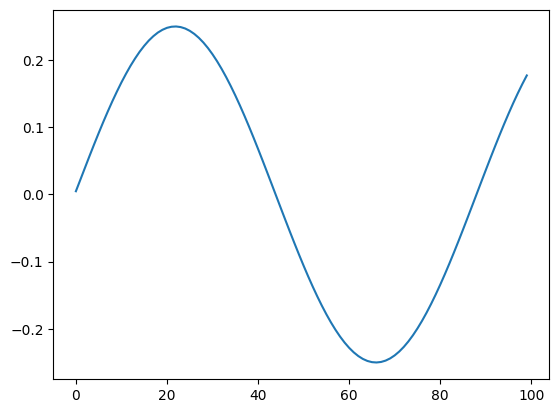

In [299]:
# Plot signal
import matplotlib.pyplot as plt
plt.plot(audio[0:100])
plt.show()

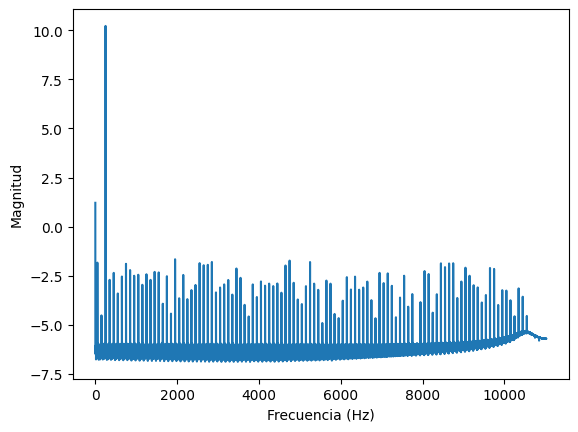

In [277]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

fft_result = np.fft.fft(audio)  # audio_byte es una lista, accedemos al primer elemento
frequencies = np.fft.fftfreq(len(fft_result), 1/sample_rate)

frequenciesGraph = frequencies[:len(frequencies)//2]
fft_resultGraph = fft_result[:len(fft_result)//2]

# Graficar la FFT
plt.plot(frequenciesGraph, np.log(fft_resultGraph))  # Usamos np.abs() para obtener la magnitud
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Magnitud')
plt.show()

Comienzo de desarrollo especifico de afinador

In [286]:
def fft_filter(fftSigP, frecuenciesSig, lowFreq, highFreq):
  fftSig = fftSigP.copy()
  # Remove all except in band
  print("Filtrando entre freq min " + str(lowFreq) + " y max " + str(highFreq))
  for i in range(len(frecuenciesSig)):
    if abs(frecuenciesSig[i]) < lowFreq or abs(frecuenciesSig[i]) > highFreq:
      fftSig[i] = 0
  return fftSig

In [260]:
def frecBetween(frecs, index1, index2):
  if index1 >= len(frecs) or index2 >= len(frecs):
    return -1
  if index1 < 0 or index2 < 0:
    return -1
  return (frecs[index1] + frecs[index2]) / 2

In [266]:
frecuenciaCuerdas = [
    329.63,
    246.94,
    196.00,
    146.83,
    110.00,
    82.41
]

filtrosCuerdas = [];

for index in range(len(frecuenciaCuerdas)):
  indexHigh = index + 1;
  if indexHigh == len(frecuenciaCuerdas):
    indexHigh = -1;

  indexLow = index - 1;

  frecHigh = frecBetween(frecuenciaCuerdas, index, indexHigh);
  frecLow = frecBetween(frecuenciaCuerdas, indexLow, index);

  if frecHigh == -1:
    frecHigh = frecuenciaCuerdas[index] * 0.8;
  if frecLow == -1:
    frecLow = frecuenciaCuerdas[index] * 1.2;

  filtrosCuerdas.append([frecLow, frecHigh]);

print(filtrosCuerdas);

[[395.556, 288.28499999999997], [288.28499999999997, 221.47], [221.47, 171.41500000000002], [171.41500000000002, 128.41500000000002], [128.41500000000002, 96.205], [96.205, 65.928]]


In [288]:
# Apply filters
fft_filter_by_cuerda = [None] * len(filtrosCuerdas)

for index in range(len(filtrosCuerdas)):
  fft_filter_by_cuerda[index] = fft_filter(fft_result, frequencies, filtrosCuerdas[index][1], filtrosCuerdas[index][0])

Filtrando entre freq min 288.28499999999997 y max 395.556
Filtrando entre freq min 221.47 y max 288.28499999999997
Filtrando entre freq min 171.41500000000002 y max 221.47
Filtrando entre freq min 128.41500000000002 y max 171.41500000000002
Filtrando entre freq min 96.205 y max 128.41500000000002
Filtrando entre freq min 65.928 y max 96.205


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


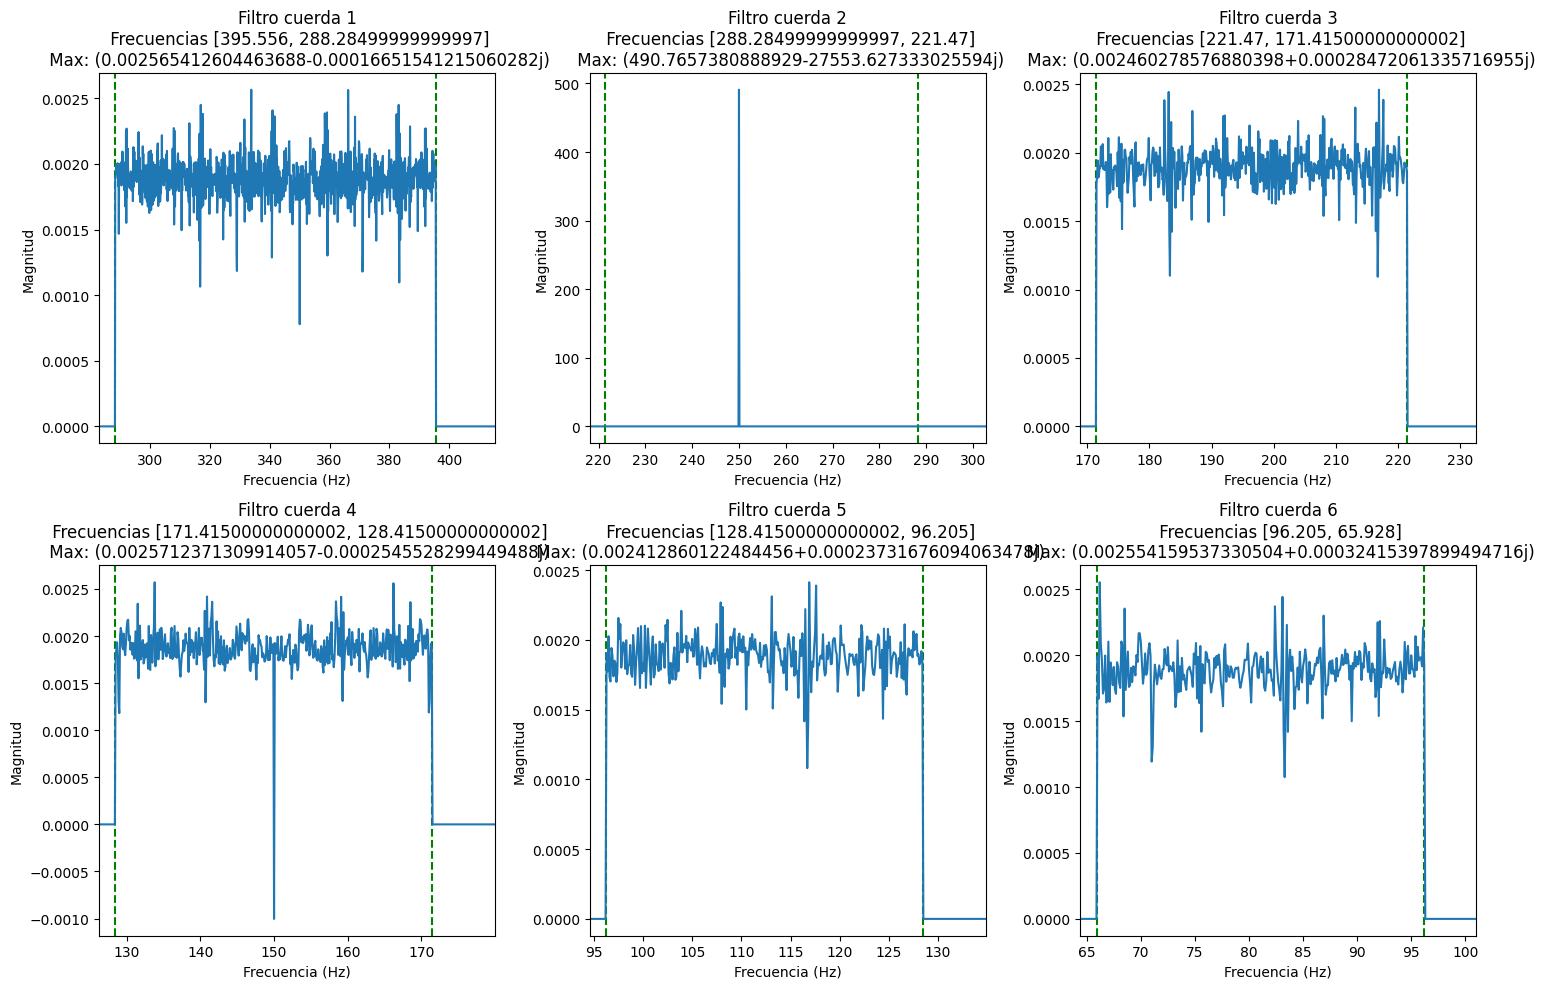

In [289]:
import matplotlib.pyplot as plt
# Definir el número de filas y columnas de la cuadrícula
num_filas = 2  # Ajusta según la cantidad de cuerdas
num_columnas = 3  # Ajusta según la cantidad de cuerdas

# Crear la figura y los subplots
fig, axs = plt.subplots(num_filas, num_columnas, figsize=(15, 10))

# Iterar sobre los FFTs y los subplots
for i in range(num_filas):
  for j in range(num_columnas):
    index = i * num_columnas + j
    if index < len(fft_filter_by_cuerda):
      fftLocal = fft_filter_by_cuerda[index]
      fftLocal = fftLocal[:len(fftLocal)//2]
      maxx = np.max(fftLocal)
      texto = "Filtro cuerda " + str(index + 1) + "\n Frecuencias [" + str(filtrosCuerdas[index][0]) + ", " + str(filtrosCuerdas[index][1]) + "]"
      texto += "\n Max: " + str(maxx)
      # Marcar con verde el min y max frec
      axs[i, j].axvline(x=filtrosCuerdas[index][0], color='g', linestyle='--')
      axs[i, j].axvline(x=filtrosCuerdas[index][1], color='g', linestyle='--')
      axs[i, j].set_xlim(xmax= filtrosCuerdas[index][0]*1.05)
      axs[i, j].set_title(texto)
      axs[i, j].plot(frequenciesGraph, (fftLocal))
      axs[i, j].set_xlabel('Frecuencia (Hz)')
      axs[i, j].set_ylabel('Magnitud')
    else:
      # Si hay más subplots que datos, los ocultamos
      axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [292]:
# Obtengo cuerda con mayor coincidencia
maxPorCuerda = np.zeros(len(fft_filter_by_cuerda))
for index in range(len(fft_filter_by_cuerda)):
  maxPorCuerda[index] = np.max(fft_filter_by_cuerda[index])

cuerdaDominante = np.argmax(maxPorCuerda) + 1
print("Cuerda dominante: " + str(cuerdaDominante))

Cuerda dominante: 2


<ipython-input-292-a61e13c5adb2>:4: ComplexWarning: Casting complex values to real discards the imaginary part
  maxPorCuerda[index] = np.max(fft_filter_by_cuerda[index])


In [293]:
frecDom = frecuenciaCuerdas[cuerdaDominante - 1]
print("Frecuencia dominante: " + str(frecDom))

Frecuencia dominante: 246.94


In [297]:
#obtengo la max frecuencia del fft
indexFFT = np.argmax(fft_filter_by_cuerda[cuerdaDominante - 1])
frecuenciaMedida = frequencies[indexFFT]
print("Frecuencia medida: " + str(frecuenciaMedida))

Frecuencia medida: 250.0


In [298]:
if frecuenciaMedida > frecDom:
  print("Destensar la cuerda")
else:
  print("Aumentar la tension de la cuerda");

Destensar la cuerda
